In [1]:
import torchvision
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from network_class import *
from sequence_dataset import *
from utils import *


In [2]:
# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seed
torch.manual_seed(999)

# network hypers
adap_neuron = True  # whether use adaptive neuron or not
dp = 0.2
onetoone = True
num_readout = 10

# seq data set config
seq_len = 40  # sequence length
random_switch = False  # predictable or random switch time
switch_time = [seq_len / 2]  # if not random switch, provide switch time
num_switch = 1  # used when random switch=T

n_classes = 10

cuda


## load test data and model


In [3]:
###############################################################
# IMPORT DATASET
###############################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 200

testdata = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

seq_test = SequenceDatasetPredictable(testdata, testdata.targets, seq_len, random_switch,
                           switch_time, num_switch)

test_loader = torch.utils.data.DataLoader(seq_test, batch_size=batch_size,
                                          shuffle=False, num_workers=3)

for batch_idx, (data, target) in enumerate(test_loader):
    print(data.shape)
    print(target.shape)
    break


num of sequences created: 10000
torch.Size([200, 40, 28, 28])
torch.Size([200, 40])


In [4]:
# ##############################################################
# DEFINE NETWORK
# ##############################################################

# set input and t param
IN_dim = 784
hidden_dim = [10 * num_readout, 784]

# define network
model_bp = SnnNetworkSeq(IN_dim, hidden_dim, n_classes, is_adapt=adap_neuron, one_to_one=onetoone,
                      dp_rate=dp)
model_bp.to(device)
print(model_bp)


model_fptt = SnnNetworkSeq(IN_dim, hidden_dim, n_classes, is_adapt=adap_neuron, one_to_one=onetoone,
                      dp_rate=dp)
model_fptt.to(device)


# define new loss and optimiser
total_params = count_parameters(model_bp)
print('total param count %i' % total_params)


SnnNetworkSeq(
  (dp): Dropout(p=0.2, inplace=False)
  (r_in_rec): SnnLayer(
    (rec_w): Linear(in_features=784, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (rin2rout): Linear(in_features=784, out_features=100, bias=True)
  (rout2rin): Linear(in_features=100, out_features=784, bias=True)
  (r_out_rec): SnnLayer(
    (rec_w): Linear(in_features=100, out_features=100, bias=True)
    (sigmoid): Sigmoid()
  )
  (output_layer): OutputLayer(
    (sigmoid): Sigmoid()
  )
)
total param count 785886


In [5]:
exp_dir_bp = '/home/lucy/spikingPC/results/Feb-13-2023/bp_noener_fpttalpha02_curr0/'
saved_dict_bp = model_result_dict_load(exp_dir_bp + 'onelayer_rec_best.pth.tar')

model_bp.load_state_dict(saved_dict_bp['state_dict'])
model_bp.eval()

exp_dir_fptt = '/home/lucy/spikingPC/results/Feb-13-2023/fptt_noener_fpttalpha02_curr0/'
saved_dict_fptt = model_result_dict_load(exp_dir_fptt + 'onelayer_rec_best.pth.tar')

model_fptt.load_state_dict(saved_dict_fptt['state_dict'])
model_fptt.eval()

SnnNetworkSeq(
  (dp): Dropout(p=0.2, inplace=False)
  (r_in_rec): SnnLayer(
    (rec_w): Linear(in_features=784, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (rin2rout): Linear(in_features=784, out_features=100, bias=True)
  (rout2rin): Linear(in_features=100, out_features=784, bias=True)
  (r_out_rec): SnnLayer(
    (rec_w): Linear(in_features=100, out_features=100, bias=True)
    (sigmoid): Sigmoid()
  )
  (output_layer): OutputLayer(
    (sigmoid): Sigmoid()
  )
)

In [6]:
def get_seq_states(model):
    #  get all analysis data in sequence condition
    test_loss = 0
    correct = 0
    correct_end_of_seq = 0

    hiddens_all = []
    predictions_all = []
    targets_all = []

    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        targets_all.append(target)
        data, target = data.to(device), target.to(device)
        data = data.view(-1, seq_len, model.in_dim)

        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))

            log_softmax_outputs, hidden, pred_hist = model.inference(data, hidden, seq_len)
            hiddens_all.append(hidden)
            predictions_all.append(pred_hist.T)

            # compute loss at each time step
            for t in range(seq_len):
                test_loss += F.nll_loss(log_softmax_outputs[t], target[:, t], reduction='sum').data.item()

        correct += pred_hist.T.eq(target.data).cpu().sum()
        # only check end of sequence acc 
        correct_end_of_seq += pred_hist.T[:, int(seq_len / 2) - 1].eq(target[:, int(seq_len / 2) - 1].data).cpu().sum()
        correct_end_of_seq += pred_hist.T[:, seq_len - 1].eq(target[:, seq_len - 1].data).cpu().sum()
        torch.cuda.empty_cache()

    test_loss /= len(test_loader.dataset)  # per t loss
    test_acc = 100. * correct / len(test_loader.dataset) / seq_len
    test_acc_endofseq = 100 * correct_end_of_seq / len(test_loader.dataset) / 2

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), End of seq acc: {:.2f}%\n'.format(
        test_loss, int(correct / seq_len), len(test_loader.dataset),
        test_acc, test_acc_endofseq))

    predictions_all = torch.stack(predictions_all).view(-1, seq_test.seq_len)
    targets_all = torch.stack(targets_all).view(-1, seq_test.seq_len)

    return hiddens_all, predictions_all, targets_all

In [7]:
_, pred_bp, target_bp = get_seq_states(model_bp)
_, pred_fptt, target_fptt = get_seq_states(model_fptt)
print(pred_bp.size())


Test set: Average loss: 48.1820, Accuracy: 7207/10000 (72%), End of seq acc: 88.50%


Test set: Average loss: 40.6075, Accuracy: 7561/10000 (76%), End of seq acc: 89.36%

torch.Size([10000, 40])


In [8]:
pred_bp[0, :]

tensor([3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0')

In [9]:
acc_byt = {
    'alg type': [], 
    'acc at t': []
}

acc_byt['alg type'] = ['bp'] * 40 + ['fptt'] * 40
acc_byt['acc at t'] = torch.concatenate(((pred_bp.cpu() == target_bp).float().mean(dim=0), (pred_fptt.cpu() == target_fptt).float().mean(dim=0))).numpy()
acc_byt['t'] = np.concatenate((np.arange(40), np.arange(40)))
print(len(acc_byt['acc at t']))

80


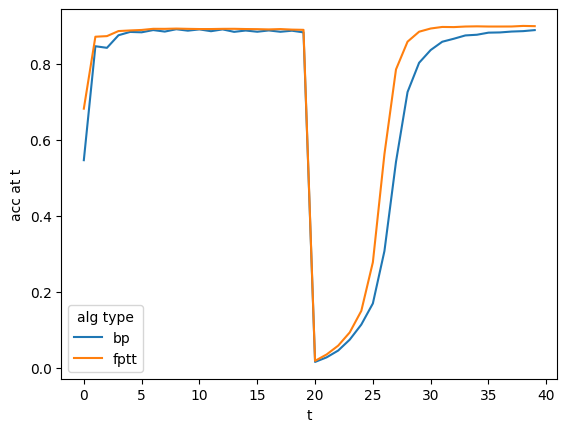

In [10]:
df_acc = pd.DataFrame.from_dict(acc_byt)
sns.lineplot(df_acc, x='t', y='acc at t', hue='alg type')
plt.show()